In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras.layers import *
from keras.models import Model,Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
emotion_labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

In [3]:
num_classes=len(emotion_labels)

In [4]:
fer_data=h5py.File('./data.h5','r',driver='core')

In [5]:
fer_x=np.asarray(fer_data['Training_pixel']).reshape(28709,48,48,1)

In [6]:
fer_y=fer_data['Training_label']

In [7]:
X_train=fer_x

In [8]:
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48,48,1))

In [9]:
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48,48,1))

In [10]:
num_train=X_train.shape[0]

In [11]:
num_val_public=X_test_public.shape[0]

In [12]:
num_val_private=X_test_private.shape[0]

In [13]:
print('Training:',X_train.shape)

Training: (28709, 48, 48, 1)


In [14]:
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 48, 48, 1)


In [15]:
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 48, 48, 1)


In [16]:
Y_train=fer_data['Training_label']

In [17]:
Y_train=to_categorical(Y_train,num_classes)

In [18]:
Y_test_public=fer_data['PublicTest_label']

In [19]:
Y_test_private=fer_data['PrivateTest_label']

In [20]:
Y_test_public=to_categorical(Y_test_public,num_classes)

In [21]:
Y_test_private=to_categorical(Y_test_private,num_classes)

In [22]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [23]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [24]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [25]:
def get_nn_model():
    model=Sequential()
    
    model.add(Flatten(input_shape=(48,48,1)))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [26]:
from keras.layers import Convolution2D,Activation,BatchNormalization,MaxPooling2D,Dropout,Dense,Flatten,AveragePooling2D

In [27]:
from keras.models import Sequential

In [28]:
def get_cnn_model():
    model=Sequential()
    
    model.add(Convolution2D(64,(3,1),padding='same',input_shape=(48,48,1)))
    model.add(Convolution2D(64,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128,(3,1),padding='same'))
    model.add(Convolution2D(128,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(256,(3,1),padding='same'))
    model.add(Convolution2D(256,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(512,(3,1),padding='same'))
    model.add(Convolution2D(512,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [29]:
cnn_model=get_cnn_model()

In [30]:
nn_model=get_nn_model()

In [31]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       2

In [32]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1180160   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)              

In [33]:
from keras.preprocessing.image import ImageDataGenerator

In [34]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [35]:
from keras import backend as K

In [36]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [37]:
def train_cnn_model(model):
    filepath='../opt/fer-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,mode='auto')
    reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=0,mode='auto',cooldown=0,min_lr=0)
    early_stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto')
    datagen=ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=False,
    )
    
    datagen.fit(X_train)
    datagen.fit(X_test_public)
    datagen.fit(X_test_private)
    batch_size=32
    
    num_epochs=200
    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                 metrics=[fbeta,'acc'])
    train_flow=datagen.flow(X_train,Y_train,batch_size=batch_size)
    test_flow_public=datagen.flow(X_test_public,Y_test_public)
    test_flow_private=datagen.flow(X_test_private,Y_test_private)
    #history=cnn_model.fit_generator(train_flow,
     #                              step_per_epoch=len(X_train)/batch_size,
     #                              epochs=num_epochs,
     #                              verbose=1,
     #                              test_data=test_flow,
     #                              test_steps=len(X_test)/batch_size,
     #                              callbacks=[checkpointer,reduce_lr,checkpointer])
    history_public = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_public, 
                    validation_steps=len(X_test_public) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    history_private = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_private, 
                    validation_steps=len(X_test_private) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history_public,history_private,model

In [38]:
def train_nn_model(model):
    filepath='../opt/fer-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,mode='auto')
    reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=0,mode='auto',cooldown=0,min_lr=0)
    early_stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto')
    datagen=ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=False,
    )
    
    datagen.fit(X_train)
    datagen.fit(X_test_public)
    datagen.fit(X_test_private)
    batch_size=32
    
    num_epochs=200
    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                 metrics=[fbeta,'acc'])
    train_flow=datagen.flow(X_train,Y_train,batch_size=batch_size)
    test_flow_public=datagen.flow(X_test_public,Y_test_public)
    test_flow_private=datagen.flow(X_test_private,Y_test_private)
    #history=cnn_model.fit_generator(train_flow,
     #                              step_per_epoch=len(X_train)/batch_size,
     #                              epochs=num_epochs,
     #                              verbose=1,
     #                              test_data=test_flow,
     #                              test_steps=len(X_test)/batch_size,
     #                              callbacks=[checkpointer,reduce_lr,checkpointer])
    history_public = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_public, 
                    validation_steps=len(X_test_public) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    history_private = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_private, 
                    validation_steps=len(X_test_private) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history_public,history_private,model

In [39]:
history_public,history_private,cnn_model = train_cnn_model(cnn_model)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
898/897 [==============================] - ETA: 0s - loss: 1.6513 - fbeta: 0.1791 - acc: 0.3754
Epoch 00001: saving model to ../opt/fer-cnn/Model.01-0.4586.hdf5

Epoch 00001: saving model to ../opt/fer-cnn/Model.01-0.4586.hdf5
898/897 [==============================] - 16s 18ms/step - loss: 1.6513 - fbeta: 0.1791 - acc: 0.3754 - val_loss: 1.4145 - val_fbeta: 0.2367 - val_acc: 0.4586
Epoch 2/200
897/897 [============================>.] - ETA: 0s - loss: 1.3571 - fbeta: 0.2819 - acc: 0.4812
Epoch 00002: saving model to ../opt/fer-cnn/Model.02-0.4798.hdf5

Epoch 00002: saving model to ../opt/fer-cnn/Model.02-0.4798.hdf5
898/897 [==============================] - 16s 17ms/step - loss: 1.3572 - fbeta: 0.2819 - acc: 0.4812 - val_loss: 1.3340 - val_fbeta: 0.2212 - val_acc: 0.4798
Epoch 3/200
896/897 [============================>.] - ETA: 0s - loss: 1.2598 - fbeta: 0.3221 - acc: 0.5182
Epoch 00003: saving 

In [40]:
history_public_nn,history_private_nn,nn_model = train_nn_model(nn_model)

Epoch 1/200
888/897 [============================>.] - ETA: 0s - loss: 1.7784 - fbeta: 0.0820 - acc: 0.3036
Epoch 00001: saving model to ../opt/fer-nn/Model.01-0.3330.hdf5

Epoch 00001: saving model to ../opt/fer-nn/Model.01-0.3330.hdf5
898/897 [==============================] - 5s 5ms/step - loss: 1.7766 - fbeta: 0.0821 - acc: 0.3042 - val_loss: 1.6755 - val_fbeta: 0.0462 - val_acc: 0.3330
Epoch 2/200
892/897 [============================>.] - ETA: 0s - loss: 1.6415 - fbeta: 0.1034 - acc: 0.3542
Epoch 00002: saving model to ../opt/fer-nn/Model.02-0.3695.hdf5

Epoch 00002: saving model to ../opt/fer-nn/Model.02-0.3695.hdf5
898/897 [==============================] - 5s 5ms/step - loss: 1.6417 - fbeta: 0.1033 - acc: 0.3543 - val_loss: 1.6036 - val_fbeta: 0.0781 - val_acc: 0.3695
Epoch 3/200
893/897 [============================>.] - ETA: 0s - loss: 1.5974 - fbeta: 0.1153 - acc: 0.3726
Epoch 00003: saving model to ../opt/fer-nn/Model.03-0.3773.hdf5

Epoch 00003: saving model to ../opt/fer

In [41]:
def eval_model_public(history,model):
    batch_size=32
    score=model.evaluate(X_test_public,Y_test_public,steps=(int)(len(X_test_public)/batch_size))
    print('Evaluation loss:',score[0])
    print('Evaluation accuracy:',score[1])
                        
    plt.plot(history.history['acc'],color='b',label='Training')
    plt.plot(history.history['val_acc'],color='g',label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()
                         
    plt.plot(history.history['loss'],color='b',label='Training')
    plt.plot(history.history['val_loss'],color='g',label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
                         
    y_pred=model.predict_classes(X_test_public)
    y_true=np.asarray([np.argmax(i) for i in Y_test_public])
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm=confusion_matrix(y_true,y_pred)
    cm_normalised=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(cm_normalised,
                  annot=True,
                  linewidths=0,
                  square=False,
                  cmap="Greens",
                  yticklabels=emotion_labels,
                  xticklabels=emotion_labels,
                  vmin=0,
                  vmax=np.max(cm_normalised),
                  fmt=".2f",
                  annot_kws={"size":20})
    ax.set(xlabel='Predicted label',ylabel='True label')

In [42]:
def eval_model_private(history,model):
    batch_size=32
    score=model.evaluate(X_test_private,Y_test_private,steps=(int)(len(X_test_private)/batch_size))
    print('Evaluation loss:',score[0])
    print('Evaluation accuracy:',score[1])
                        
    plt.plot(history.history['acc'],color='b',label='Training')
    plt.plot(history.history['val_acc'],color='g',label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()
                         
    plt.plot(history.history['loss'],color='b',label='Training')
    plt.plot(history.history['val_loss'],color='g',label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
                         
    y_pred=model.predict_classes(X_test_private)
    y_true=np.asarray([np.argmax(i) for i in Y_test_private])
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm=confusion_matrix(y_true,y_pred)
    cm_normalised=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(cm_normalised,
                  annot=True,
                  linewidths=0,
                  square=False,
                  cmap="Greens",
                  yticklabels=emotion_labels,
                  xticklabels=emotion_labels,
                  vmin=0,
                  vmax=np.max(cm_normalised),
                  fmt=".2f",
                  annot_kws={"size":20})
    ax.set(xlabel='Predicted label',ylabel='True label')

109/112 [============================>.] - 1s 7ms/step - loss: 1.0520 - fbeta: 0.6103 - acc: 0.6604
Evaluation loss: 1.0519787073135376
Evaluation accuracy: 0.6102863550186157


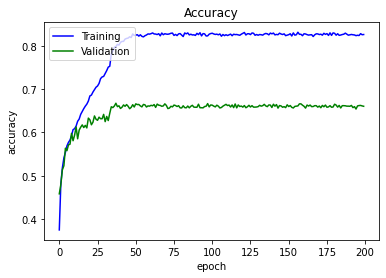

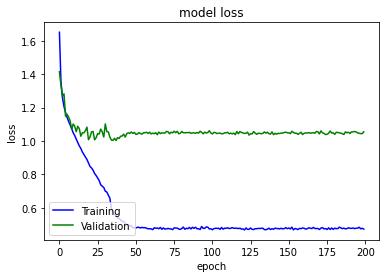

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


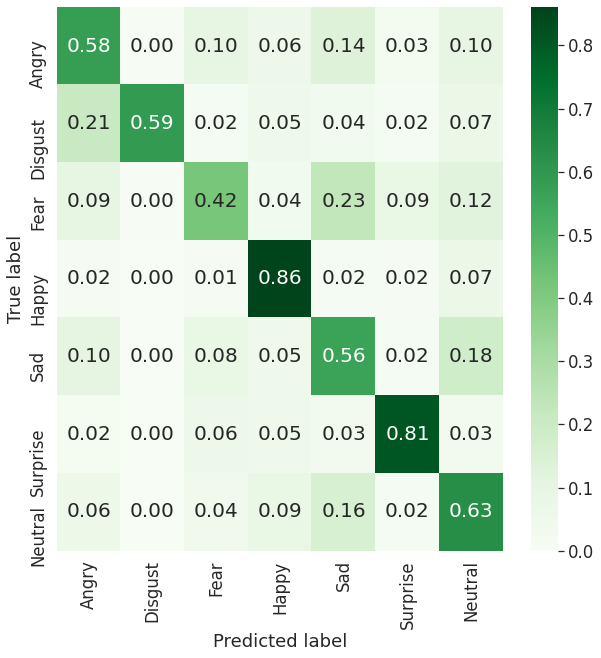

In [43]:
eval_model_public(history_public, cnn_model)

109/112 [============================>.] - 1s 7ms/step - loss: 0.9900 - fbeta: 0.6330 - acc: 0.6807
Evaluation loss: 0.9900187849998474
Evaluation accuracy: 0.6329830288887024


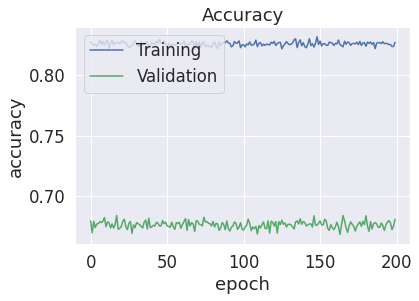

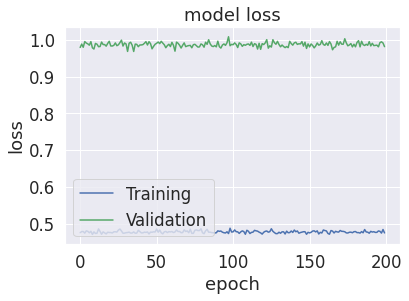

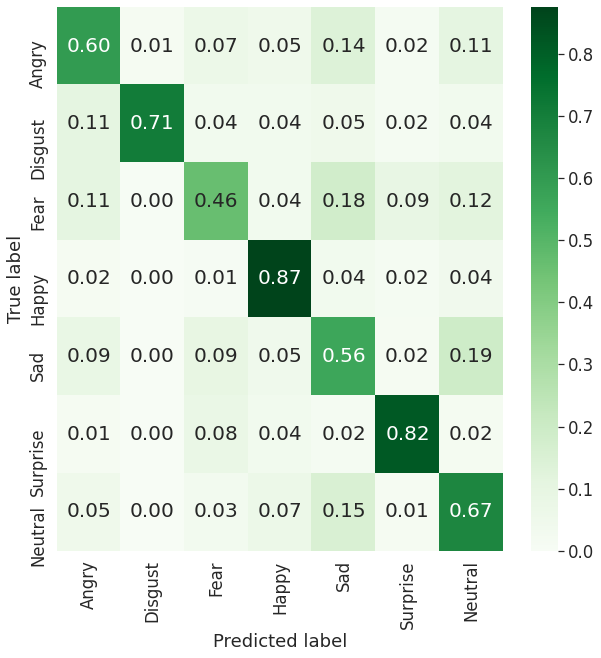

In [44]:
eval_model_private(history_private, cnn_model)

109/112 [============================>.] - 0s 3ms/step - loss: 1.4434 - fbeta: 0.3593 - acc: 0.4921
Evaluation loss: 1.443395733833313
Evaluation accuracy: 0.3592550754547119


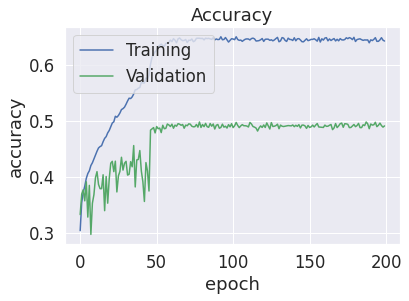

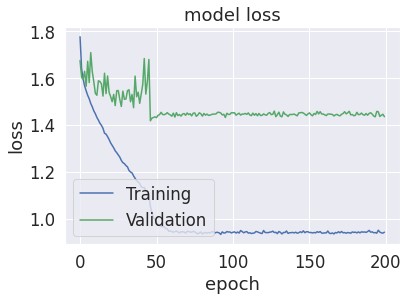

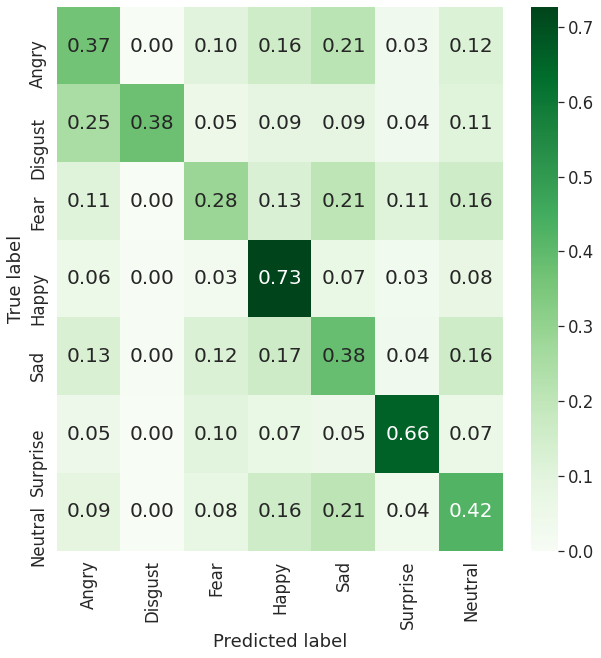

In [45]:
eval_model_public(history_public_nn, nn_model)

109/112 [============================>.] - 0s 3ms/step - loss: 1.4004 - fbeta: 0.3679 - acc: 0.5063
Evaluation loss: 1.4003742933273315
Evaluation accuracy: 0.36788445711135864


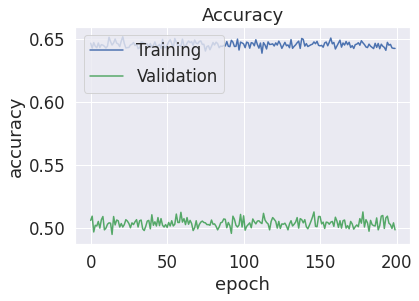

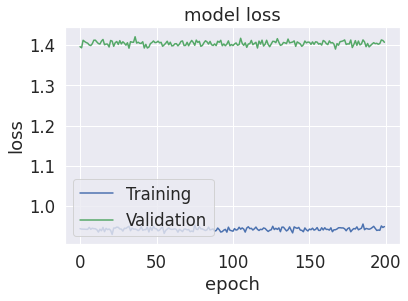

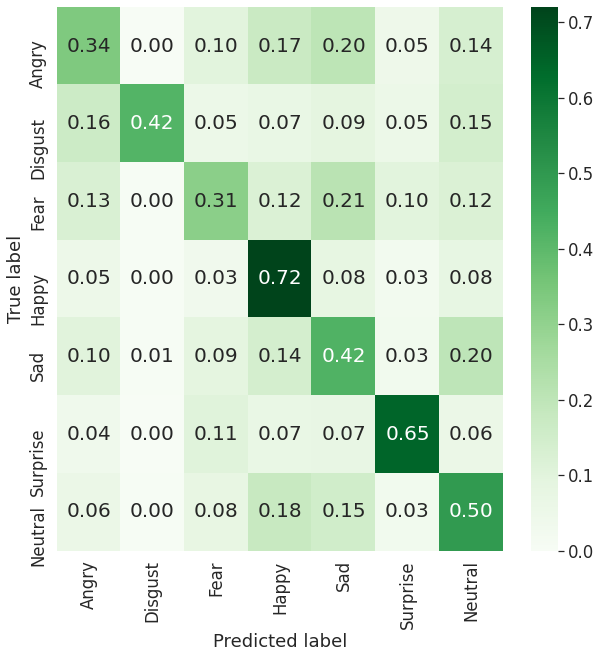

In [46]:
eval_model_private(history_private_nn, nn_model)